In [ ]:
!pip install imutils

: 

## Classificação de imagens de tempo

**Classificação de Imagens**

> Classificação de imagens de tempo utilizando técnicas clássicas de Processamento Digital de Imagens e treinar classificadores para predição dos atributos.

In [2]:
### Módulos necessáriosimport os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MaxAbsScaler
from skimage import io, img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import random
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MaxAbsScaler

- **Preparando o dataset**

> Neste primeiro momento há necessidade de observar as imagens do dataset e organizá-las em uma estrutura de dados adequada para que seus atributos possam ser extraídos. há então a necessidade de carregar o conjunto de imagens via código.

In [3]:
def load_data(datadir, classes, img_size=100):
    training_data = []
    label = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        shuffle(shufled_list)
        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (img_size, img_size))
            #img_array = cv2.resize(img_array, (img_size, img_size)).flatten()
            
            training_data.append(img_array)
            label.append(classe)
            
    return training_data, label

In [4]:
data, label = load_data('dataset/tempo', ['cloudy','rain','shine','sunrise'])

- O código acima realiza a implementação de uma função que recebe 3 argumentos: o diretório que contem as pastas das imagens, uma lista de string que contém o nome das classes que devem ser reconhecidas e um parâmetro default que é o  tamanho da imagem que será utilizado em todo o processo. 


- São definidas duas listas vazias training_data e label. Em ***training_data*** serão armazenadas as imagens e em ***label*** serão definidos números que representam cada classe. Deste modo, é possível saber a classe da imagem que estiver na posição 5 da lista training_data observando o número contido da quinta posição da lista label.

- Um loop for é realizado para iterar sobre as possíveis classes. Assim a variável classe, definida no loop, poderá assumir valores variando de  0 até 3, em que 0 representa classe **'cloudy'** e 3 representa a classe **'sunrise'**. Na variável path é armazenada a string que contem o caminho para pasta de imagens da classe específica, conforme iteração do loop for e na estrutura shufled_list são contidas strings que são os caminhos de cada imagem da classe, já com um primeiro embaralhamento.

### Extração de atributos

> Definir dois métodos para obter uma imagem de entrada e convertê-la em um vetor de recursos ou uma lista de números que quantificam o conteúdo de uma imagem:




In [5]:
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

> A função aceita uma imagem de entrada e constrói um histograma de cores para caracterizar a distribuição de cores da imagem.



In [6]:
from skimage import exposure
def extract_color_histogram(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    # realizar a equalização do histograma
    image_eq = exposure.equalize_hist(imgRealcada)
    # determinar a media do valor dos pixels que ocorrem na imagem  equalizada
    img_mean_eq = np.mean(image_eq)*255
    return image_eq.flatten()

def extract_color_histogram2(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    #hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    
    hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    #hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [0, 180, 0, 256, 0, 256])
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    #print(hist)
    hist_norm = cv2.normalize(hist, hist)
    #print(hist_norm)
    return hist_norm.flatten()

In [7]:
# média	da	cor	dos pixels
def mean_normal(image):
    return cv2.mean(image)

# média	da	cor	dos pixels
def mean_realce(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    return cv2.mean(imgRealcada)

def extract_histogram(image):
    '''imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    #hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)'''
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    return hist_norm.flatten()

def extract_histogram_realce(image):
    imgSuavizada = cv2.GaussianBlur(image, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(image, imgSuavizada)
    imgRealcada = cv2.add(image, imgDetalhes)
    
    hsv = cv2.cvtColor(imgRealcada, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8, 8, 8), [ 0 , 256 , 0 , 256 , 0 , 256 ])
    hist_norm = cv2.normalize(hist, hist)
    return hist_norm.flatten()

In [8]:
features = []
def features_extraction(images):
    features_list = []
    for image in images:
        #print(image.shape)
        hist = extract_histogram_realce(image)
        features.append(hist)
    return features

features = features_extraction(data)

- **Treinamento e Teste dos Classificadores.**
> A variável features possui as os atributos extraídos das imagens. Neste contexto, a função gen_classifiers é iamplementada para retornar testes em 7 classificadores: Random Forest, MLP, KNN, SGDC, SVM, Árvore de decisão e Naive Bayes.

In [9]:
def generate_svm_model(train_data,label_train_data,test_data):
    clf = svm.SVC(kernel='linear')
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_SGDC_model(train_data,label_train_data,test_data):
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_naive_bayes_model(train_data,label_train_data,test_data):
    gnb = GaussianNB()
    gnb.fit(train_data, label_train_data)
    predicted = gnb.predict(test_data)
    return predicted
def generate_decision_tree_model(train_data,label_train_data,test_data):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_random_forest_model(X_train, y_train,test_data):
    rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 8, max_features='auto', n_estimators=200)
    rfc.fit(X_train,y_train)
    predicted = rfc.predict(test_data)
    return predicted
def generate_MLP_model(X_train, y_train,test_data):
    classifier = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(test_data)
    return predicted
def generate_knn_model(train_data,label_train_data,test_data):
    knn = KNeighborsClassifier()
    knn.fit(train_data,label_train_data)
    predicted = knn.predict(test_data)
    return predicted

In [10]:
def gen_classifiers(train_data,label_train_data,test_data):
    return generate_knn_model(train_data,label_train_data,test_data),\
    generate_MLP_model(train_data,label_train_data,test_data),\
    generate_SGDC_model(train_data,label_train_data,test_data),\
    generate_svm_model(train_data,label_train_data,test_data),\
    generate_decision_tree_model(train_data,label_train_data,test_data),\
    generate_naive_bayes_model(train_data,label_train_data,test_data),\
    generate_random_forest_model(train_data,label_train_data,test_data),

In [11]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.3)
results = gen_classifiers(X_train, y_train,X_test)

- A função divide o conjunto de atributos e labels em conjuntos de treino e teste para garantirmos que o processo de treinamento seja realizado com dados distintos dos que vão ser testados por cada classificador.

- Deste modo, a função gen_classifiers recebe os atributos de treinamento, as labels dos atributos de treinamento e os atribiutos de teste e retorna um array de valores que indicam os resultados dos testes de cada classificador. Cada classificador é inicializado com um objeto específico. Após a inicialização é realizado o comando fit para treinar o classificadorque recebe os atribiutos de treinamento e as labels dos atributos. Após o treinamento é realizado o comando predict para testar se o classificador realiza uma predição correta de atributos que não foram utilizados no conjunto de treinamento. A variável predicted é um vetor em que cada elemento do vetor é um valor que indica a classe a qual o atributo pertence. 

- **Avaliação dos classificadores**
> A biblioteca sklearn possui funções que auxiliam a medir quantitativamente o desempenho do classificador. A acurácia do classificador pode ser medida pela chamada da função seguinte:

In [12]:
acc_knn = metrics.accuracy_score(y_test, results[0])
acc_MLP = metrics.accuracy_score(y_test, results[1])
acc_SGDC = metrics.accuracy_score(y_test, results[2])
acc_svm = metrics.accuracy_score(y_test, results[3])
acc_decision_tree = metrics.accuracy_score(y_test, results[4])
acc_naive_bayes = metrics.accuracy_score(y_test, results[5])
acc_random_forest = metrics.accuracy_score(y_test, results[6])

print("Acc KNN: {:.3f}".format(acc_knn))
print("Acc MLP: {:.3f}".format(acc_MLP))
print("Acc SGDC: {:.3f}".format(acc_SGDC))
print("Acc svm: {:.3f}".format(acc_svm))
print("Acc decision_tree: {:.3f}".format(acc_decision_tree))
print("Acc naive_bayes: {:.3f}".format(acc_naive_bayes))
print("Acc random_forest: {:.3f}".format(acc_random_forest))

Acc KNN: 0.825
Acc MLP: 0.831
Acc SGDC: 0.843
Acc svm: 0.843
Acc decision_tree: 0.795
Acc naive_bayes: 0.757
Acc random_forest: 0.837


VP = Verdadeiro positivo - objeto pertence a classe A e foi classificado na classe A

VN = Verdadeiro negativo - objeto não pertence a classe A e não foi classificado na classe A

FP = Falso positivo - objeto não pertence a classe A e foi classificado na classe A

FN = Falso negativo - objeto pertence a classe A e não foi classificado na classe A

A sensibilidade/revocação/recall do classificador, por classe,  pode ser medida pela chamada da função seguinte:

In [13]:
modelo = ["KNN", "MLP", "SGDC", "SVM", "Decision_tree", "Naive_bayes", "Random_forest"]

def precision(y_test, results):
    return metrics.precision_score(y_test, results, average=None)
def recall(y_test, results):
    return metrics.recall_score(y_test, results, average=None)
def f1_score(y_test, results):
    return metrics.f1_score(y_test, results, average=None)

def printScore(modelo, avali):
    for i in range(0, len(modelo)):
        print("precision {}: {}".format(modelo[i], avali(y_test, results[i])))

print("Precision")
printScore(modelo, precision)
print("recall")
printScore(modelo, recall)
print("f1_score")
printScore(modelo, f1_score)


Precision
precision KNN: [0.74117647 0.68852459 0.85365854 0.94495413]
precision MLP: [0.72916667 0.75       0.86666667 0.92982456]
precision SGDC: [0.74725275 0.75438596 0.85185185 0.96296296]
precision SVM: [0.7244898  0.7826087  0.86585366 0.95495495]
precision Decision_tree: [0.74418605 0.703125   0.8028169  0.87931034]
precision Naive_bayes: [0.59230769 0.72222222 0.875      0.89565217]
precision Random_forest: [0.71296296 0.92307692 0.81578947 0.93859649]
recall
precision KNN: [0.74117647 0.67741935 0.88607595 0.92792793]
precision MLP: [0.82352941 0.62903226 0.82278481 0.95495495]
precision SGDC: [0.8        0.69354839 0.87341772 0.93693694]
precision SVM: [0.83529412 0.58064516 0.89873418 0.95495495]
precision Decision_tree: [0.75294118 0.72580645 0.72151899 0.91891892]
precision Naive_bayes: [0.90588235 0.41935484 0.62025316 0.92792793]
precision Random_forest: [0.90588235 0.58064516 0.78481013 0.96396396]
f1_score
precision KNN: [0.74117647 0.68292683 0.86956522 0.93636364]
p

In [14]:
def get_confusion_matrix(y_true, y_pred, modelo):
    labels = ['cloudy','rain','shine','sunrise']
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues').set(title=modelo, ylabel='True Label', xlabel='Predicted Label')

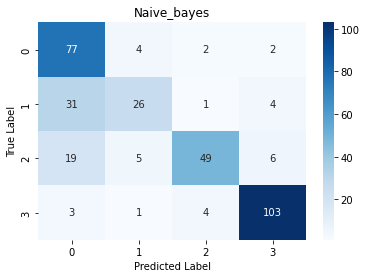

In [15]:
get_confusion_matrix(y_test, results[5], modelo[5])

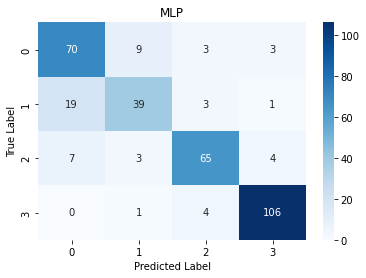

In [16]:
get_confusion_matrix(y_test, results[1], modelo[1])